In [1]:
import gymnasium as gym
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# PPO Training for Pendulum-v1
Trains and save the model
No need to run if we are using saved model


In [29]:

env = gym.make("Pendulum-v1")
env = DummyVecEnv([lambda: env]) 

model = PPO(
    "MlpPolicy", env, verbose=1, 
    learning_rate=3e-4, 
    gamma=0.99, 
    n_steps=1024,  
    batch_size=128,
    n_epochs=10,  
    clip_range=0.2, 
    ent_coef=0.0,
    tensorboard_log="./ppo_pendulum_tensorboard/"
)

model.learn(total_timesteps=20_00_000)  

model.save("ppo_pendulum")


Using cpu device
Logging to ./ppo_pendulum_tensorboard/PPO_8
-----------------------------
| time/              |      |
|    fps             | 1823 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 1024 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1436         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl            | 0.0020002155 |
|    clip_fraction        | 0.00605      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -0.00114     |
|    learning_rate        | 0.0003       |
|    loss                 | 6.35e+03     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00105     |
|    std                  | 1            

# load the model and sample trajectories

In [ ]:
model = PPO.load("ppo_pendulum")
trajectories = []
rewards_per_trajectory = []

for _ in range(200):
    obs = env.reset()
    trajectory = []
    rewards = []
    done = False
    step_count = 0
    while not done and step_count < 200:  # limit episode length to 200
        action, _ = model.predict(obs, deterministic=True)
        next_obs, reward, done, _ = env.step(action)
        trajectory.append((obs, action, reward, next_obs, done))
        rewards.append(reward)
        obs = next_obs
        step_count += 1
    trajectories.append(trajectory)
    rewards_per_trajectory.append(sum(rewards))


# save trajectories for inverse RL
## plot reward vs trajectory id

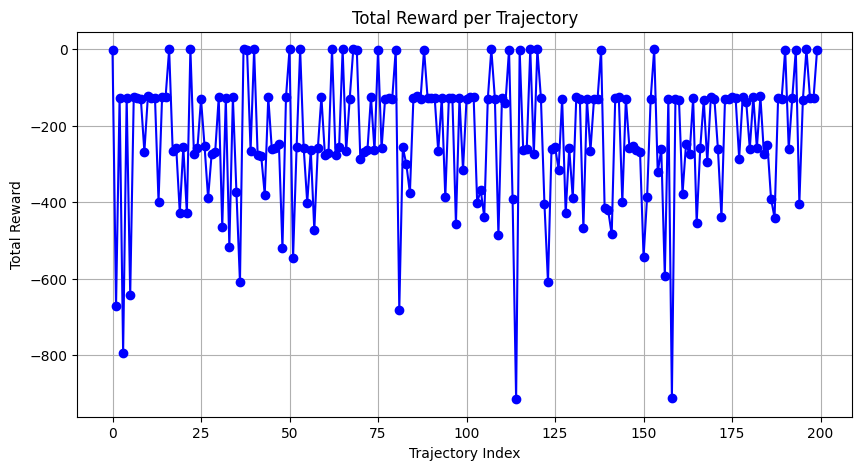

In [6]:
import pickle
# Save trajectories using pickle
with open("pendulum_trajectories.pkl", "wb") as f:
    pickle.dump(trajectories, f)

# Plot reward per trajectory
plt.figure(figsize=(10, 5))
plt.plot(range(200), rewards_per_trajectory, marker='o', linestyle='-', color='b')
plt.xlabel("Trajectory Index")
plt.ylabel("Total Reward")
plt.title("Total Reward per Trajectory")
plt.grid()
plt.show()

env.close()

# iRL

## Algorihm implementation

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from stable_baselines3 import PPO
import gym

class RBF_IRL:
    def __init__(self, 
                 expert_demos, 
                 state_space_dim, 
                 n_rbf_centers, 
                 kernel_width, 
                 learning_rate, 
                 epochs,
                 l2_regularization_lambda=0.0):
        self.expert_demos = expert_demos
        self.state_space_dim = state_space_dim
        self.n_rbf_centers = n_rbf_centers
        self.kernel_width = kernel_width
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.l2_regularization_lambda = l2_regularization_lambda
        self.rbf_centers = None
        self.weights = None  # Reward weights

    def gaussian_kernel(self, state, center):
        return np.exp(-np.linalg.norm(state - center)**2 / (2 * self.kernel_width**2))

    def generate_rbf_features(self, states):
        if self.rbf_centers is None:
            raise ValueError("RBF centers must be initialized. Call compute_rbf_centers first.")
        return np.array([[self.gaussian_kernel(s, center) for center in self.rbf_centers] for s in states])

    def compute_rbf_centers(self):
        states = np.concatenate(self.expert_demos)
        kmeans = KMeans(n_clusters=self.n_rbf_centers, random_state=0, n_init='auto').fit(states)
        self.rbf_centers = kmeans.cluster_centers_

    def compute_feature_expectations(self, trajectories):
        all_states = np.concatenate(trajectories)
        feature_matrix = self.generate_rbf_features(all_states)
        return np.mean(feature_matrix, axis=0)
    
    def train(self):
        self.compute_rbf_centers()
        self.weights = np.random.uniform(low=-1, high=1, size=self.n_rbf_centers)
        expert_feature_expectations = self.compute_feature_expectations(self.expert_demos)

        for epoch in range(self.epochs):
            dummy_rollouts = [np.random.rand(len(traj), self.state_space_dim) for traj in self.expert_demos]
            rollout_feature_expectations = self.compute_feature_expectations(dummy_rollouts)
            gradient = expert_feature_expectations - rollout_feature_expectations
            if self.l2_regularization_lambda > 0:
                gradient -= 2 * self.l2_regularization_lambda * self.weights
            self.weights += self.learning_rate * gradient
            print(f"Epoch {epoch + 1}/{self.epochs}")

    def get_reward(self, state):
        phi = self.generate_rbf_features([state]).flatten()
        return np.dot(self.weights, phi)

if __name__ == '__main__':
    env = gym.make("Pendulum-v1")
    model = PPO.load("ppo_pendulum")
    expert_demos = []
    
    for _ in range(50):
        obs, _ = env.reset()
        trajectory = []
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            trajectory.append(obs.flatten())
            obs = next_obs
        expert_demos.append(np.array(trajectory))
    

C:\Users\crfve\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


# Reward function

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

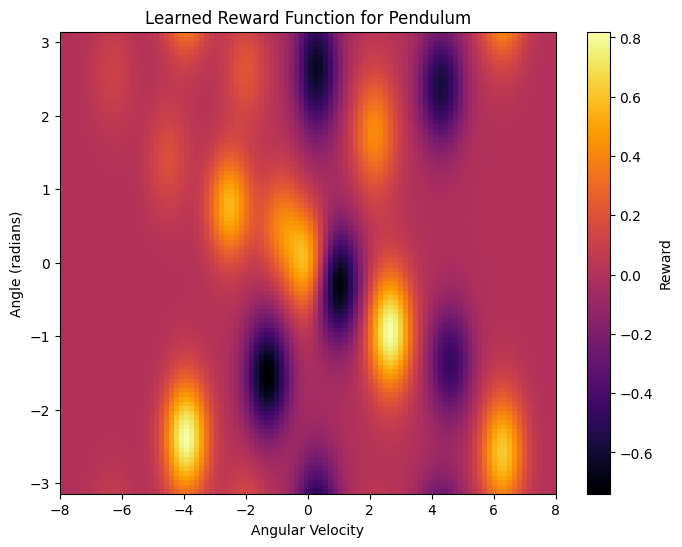

In [6]:
irl_agent = RBF_IRL(expert_demos, 3, 15, 0.5, 0.01, 100, 0.01)
irl_agent.train()

test_state = np.array([0.5, 0.3, 0.0])
reward = irl_agent.get_reward(test_state)
print(f"Reward for test state: {reward}")

# Visualization of Reward Function
theta_vals = np.linspace(-np.pi, np.pi, 100)
omega_vals = np.linspace(-8, 8, 100)
rewards = np.zeros((100, 100))

for i, theta in enumerate(theta_vals):
    for j, omega in enumerate(omega_vals):
        state = np.array([np.cos(theta), np.sin(theta), omega])
        rewards[i, j] = irl_agent.get_reward(state)

plt.figure(figsize=(8, 6))
plt.imshow(rewards, extent=[-8, 8, -np.pi, np.pi], origin='lower', aspect='auto', cmap='inferno')
plt.colorbar(label='Reward')
plt.xlabel('Angular Velocity')
plt.ylabel('Angle (radians)')
plt.title('Learned Reward Function for Pendulum')
plt.show()


# comparing

In [7]:
import numpy as np
from stable_baselines3 import PPO
import gymnasium as gym

env = gym.make("Pendulum-v1")
original_model = PPO.load("ppo_pendulum")


new_model = PPO("MlpPolicy", env, verbose=1)

# custom rewar
def custom_reward_wrapper(env, irl_agent):
    class CustomRewardEnv(gym.Wrapper):
        def __init__(self, env):
            super().__init__(env)
        def step(self, action):
            next_obs, _, terminated, truncated, info = self.env.step(action)
            reward = irl_agent.get_reward(next_obs)
            return next_obs, reward, terminated, truncated, info
    return CustomRewardEnv(env)

new_env = custom_reward_wrapper(env, irl_agent)
new_model.learn(total_timesteps=10_00_000)

# compare original and new policies by taking 20 sample episodes
def evaluate_policy(model, env, episodes=20):
    rewards = []
    for _ in range(episodes):
        obs, _ = env.reset()
        total_reward = 0
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
        rewards.append(total_reward)
    return np.mean(rewards)

original_score = evaluate_policy(original_model, env)
new_score = evaluate_policy(new_model, env)



Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.04e+03 |
| time/              |           |
|    fps             | 1664      |
|    iterations      | 1         |
|    time_elapsed    | 1         |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 200          |
|    ep_rew_mean          | -1.13e+03    |
| time/                   |              |
|    fps                  | 1079         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0019569283 |
|    clip_fraction        | 0.00513      |
|    clip_range           | 0.2         

In [8]:
print(f"Original PPO policy score: {original_score}")
print(f"New PPO policy (IRL) score: {new_score}")


Original PPO policy score: -158.5565557528467
New PPO policy (IRL) score: -188.59691219976557


# VIDEO demonstration of policies

In [15]:
import gymnasium as gym
import numpy as np
import stable_baselines3 as sb3
from gymnasium.wrappers import RecordVideo

env = gym.make("Pendulum-v1", render_mode="rgb_array")
env = RecordVideo(env, video_folder="./videos", episode_trigger=lambda e: True)

model = original_model  

obs, _ = env.reset()
done = False

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    env.render()

env.close()
print("Video saved in ./videos")


Video saved in ./videos


In [16]:
import gymnasium as gym
import numpy as np
import stable_baselines3 as sb3
from gymnasium.wrappers import RecordVideo

env = gym.make("Pendulum-v1", render_mode="rgb_array")
env = RecordVideo(env, video_folder="./videos", episode_trigger=lambda e: True)

model = new_model  

obs, _ = env.reset()
done = False

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    env.render()

env.close()
print("Video saved in ./videos")


Video saved in ./videos
